# Importación de librerías y carga de datasets
Para este caso se importan los datasets desde la creación de archivos csv a partir de las variables de entorno de matlab con extensión .m

In [0]:
#https://medium.com/@curiousily/tensorflow-for-hackers-part-ii-building-simple-neural-network-2d6779d2f91b
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

from google.colab import files
##
from time import time
##

%matplotlib inline

In [0]:
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [0]:
import sys
import torch

**Se cargan los archivos:**
Se deben cargar los siguientes archivos:

*   xx_train.csv
*   xx_valid.csv
*   xx_test.csv
*   yy_train.csv
*   yy_test.csv
*   yy_valid.csv








	 



In [0]:
#Comentar esto si no se usa colaboratory

!mkdir /content/ejercicio


# Se deben cargar 
uploaded = files.upload()



mkdir: cannot create directory ‘/content/ejercicio’: File exists


Saving xx_test.csv to xx_test (1).csv
Saving xx_train.csv to xx_train (1).csv
Saving xx_valid.csv to xx_valid (1).csv
Saving yy_test.csv to yy_test (1).csv
Saving yy_train.csv to yy_train (1).csv
Saving yy_valid.csv to yy_valid (1).csv


In [0]:
!ls

 ejercicio	   'xx_train (1).csv'  'yy_test (1).csv'   'yy_valid (1).csv'
 sample_data	    xx_train.csv        yy_test.csv	    yy_valid.csv
'xx_test (1).csv'  'xx_valid (1).csv'  'yy_train (1).csv'
 xx_test.csv	    xx_valid.csv        yy_train.csv


In [0]:
x_train =pd.read_csv('xx_train.csv', sep=';',delimiter=',',header=None)
x_test =pd.read_csv('xx_test.csv', sep=';',delimiter=',',header=None)
x_valid =pd.read_csv('xx_valid.csv', sep=';',delimiter=',',header=None)

y_train =pd.read_csv('yy_train.csv', sep=';',delimiter=',',header=None)
y_test_m =pd.read_csv('yy_test.csv', sep=';',delimiter=',',header=None)
y_valid_m =pd.read_csv('yy_valid.csv', sep=';',delimiter=',',header=None)

y_test=y_test_m[:-16]
y_valid=y_valid_m[:-16]

In [0]:
y_test[:-16]


,0
0,-1.438200
1,-1.150400
2,-0.694870
3,-0.038092
4,0.079147
...,...
1455,0.517270
1456,1.018500
1457,0.643760
1458,-0.265820


In [0]:
print(torch.__version__)
!nvcc --version
torch.cuda.is_available()

1.5.0+cu101
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


True

In [0]:
x_train

,0,1,2,3
0,0.79840,0.017826,0.67375,0.67375
1,1.24510,0.798400,0.67375,0.67375
2,1.33950,1.245100,0.67375,0.67375
3,1.25600,1.339500,0.67375,0.67375
4,1.07420,1.256000,0.67375,0.67375
...,...,...,...,...
3280,0.45082,0.445540,-0.28001,-0.28001
3281,-0.63227,0.450820,-0.28001,-0.28001
3282,-1.07050,-0.632270,-0.28001,-0.28001
3283,-0.64394,-1.070500,-0.28001,-0.28001


In [0]:
x_test_tensor = torch.from_numpy(x_test.to_numpy(dtype='float'))
y_test_tensor = torch.tensor(y_test.values,dtype=torch.float)

In [79]:



#Se define la estructura de la red
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.tanh = torch.nn.Tanh()
        
        self.linear2 = torch.nn.Linear(H,D_out)
        self.tanh2 = torch.nn.Tanh()
        self.ident = torch.nn.Identity()

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        x = self.tanh2(x)
        x = self.ident(x)
        y = x
        z = x
        return x, y, z
        #, y_pred_low,

        # tanh = torch.nn.Tanh()
        # tan= tanh(self.linear1(x))
        # y_pred = self.linear2(tanh)
        # y_upper = y_pred
        # y_lower = y_pred
        # y_crisp = y_pred
        # return y_crisp, y_lower, y_upper
        
        # x = torch.nn.Tanh(self.linear1(x))
        # y_pred = self.linear2(x)
        # return y_pred

# Funciones auxiliares para calcular los errores de penalización de los 
# intervalos superior e inferior.

def lower_loss(input,target):
  l = len(input)
  losses = torch.zeros(l)
  for i in range(l):
    e = (target[i] - input[i]).detach().numpy()
    losses[i] = torch.from_numpy(np.maximum(-e, 0)**2)
    # if e.item() < 0:
    #   losses[i] = e**2
    # else:
    #   losses[i] = torch.zeros(1)

  return losses.mean()

def upper_loss(input,target):
  l = len(input)
  losses = torch.zeros(l)
  for i in range(l):
    e = (target[i] - input[i]).detach().numpy()
    losses[i] = torch.from_numpy(np.maximum(e, 0)**2)
    # if e.item() > 0:
    #   losses[i] = e**2
    # else:
    #   losses[i] = torch.zeros(1)
  return losses.mean()

dtype = torch.double
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 500, 4, 14, 1

alpha = 20

training_epochs = 100


# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x_train_tensor = torch.from_numpy(x_train.to_numpy(dtype='float'))
y_train_tensor = torch.tensor(y_train.values,dtype=torch.float)

x_test_tensor = torch.from_numpy(x_test.to_numpy(dtype='float'))
y_test_tensor = torch.tensor(y_test.values,dtype=torch.float)


x_valid_tensor = torch.from_numpy(x_valid.to_numpy(dtype='float'))
y_valid_tensor = torch.tensor(y_valid.values,dtype=torch.float)

# Construct our model by instantiating the class defined above
model = Net(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(reduction='mean')
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Se crea un arreglo para almacenar los losses y graficarlos luego
l=np.zeros((5,training_epochs))

# TRAINING
for t in range(training_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_crisp_pred, y_lower_pred, y_upper_pred = model(x_train_tensor.float())
    # y_crisp_pred = model(x_train_tensor.float())

    y_test_pred, low,up=model(x_test_tensor.float())
    # y_test_pred=model(x_test_tensor.float())
    
    y_valid_pred, low,up=model(x_valid_tensor.float())
    # y_valid_pred=model(x_valid_tensor.float())

    loss_test = criterion(y_test_pred, y_test_tensor) 
    loss_valid = criterion(y_valid_pred, y_valid_tensor) 

    # Compute and print loss
    loss_crisp = criterion(y_crisp_pred, y_train_tensor) 
    loss_l = criterion(y_lower_pred, y_train_tensor) + alpha*lower_loss(y_lower_pred,y_train_tensor)
    loss_u = criterion(y_upper_pred, y_train_tensor) + alpha*upper_loss(y_upper_pred,y_train_tensor)
   
    l[0][t], l[1][t], l[2][t], l[3][t], l[4][t] = loss_crisp, loss_l, loss_u, loss_test, loss_valid

    # loss_to_opt_l = loss + alpha*loss_l
    # loss_to_opt_u = loss + alpha*loss_u
    
    # loss_l = 
    # print(t, loss.item())
    
    if t % 100 == 99:
      # print(y_hat)
      print(t,'loss = ' ,loss_crisp.item(),'\  loss_l = ',loss_l.item(), '\  loss_u = ',loss_u.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()

    loss_crisp.backward(retain_graph=True)
    loss_l.backward(retain_graph=True)
    loss_u.backward(retain_graph=False)
    optimizer.step()


#3099 loss =  0.5486084222793579
# loss_l =  0.21327298879623413 
# loss_u =  0.3353354036808014

99 loss =  1.2049217224121094 \  loss_l =  10.35137939453125 \  loss_u =  16.15689468383789


In [0]:
x_train_tensor

tensor([[ 0.7984,  0.0178,  0.6737,  0.6737],
        [ 1.2451,  0.7984,  0.6737,  0.6737],
        [ 1.3395,  1.2451,  0.6737,  0.6737],
        ...,
        [-1.0705, -0.6323, -0.2800, -0.2800],
        [-0.6439, -1.0705, -0.2800, -0.2800],
        [ 0.3327, -0.6439, -0.2800, -0.2800]], dtype=torch.float64)

In [0]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)


In [0]:
plt.plot(y_pred_test.detach().numpy(),label='y_pred')
plt.legend()

plt.plot(y_test,label='y_test')
plt.legend()

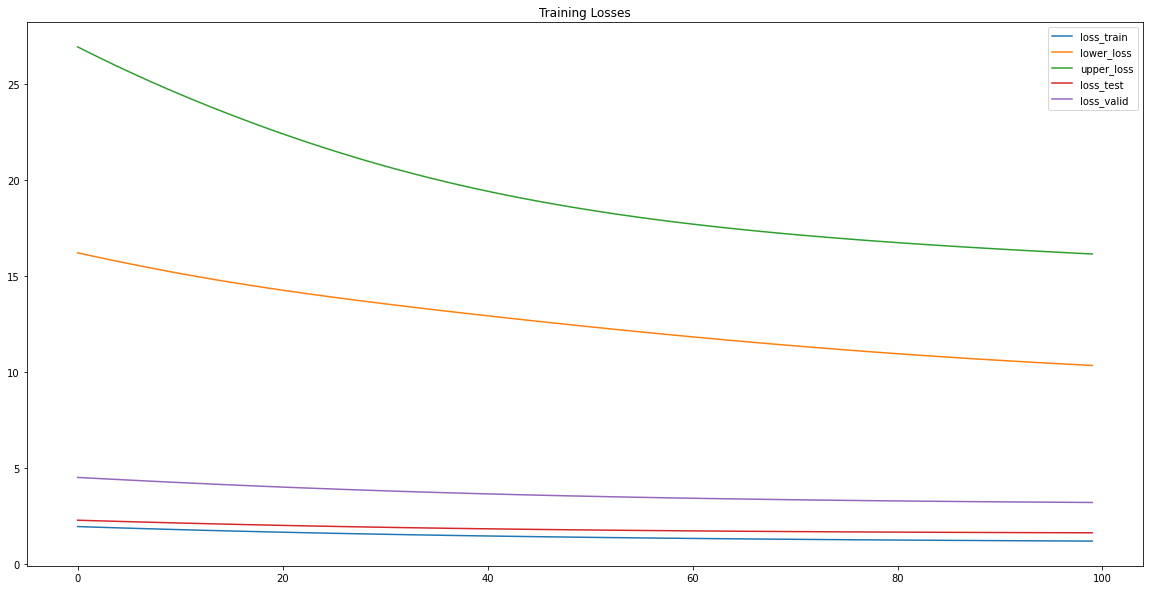

In [82]:
plt.figure(figsize=(20,10))
plt.plot(l[0][:training_epochs],label = 'loss_train')

plt.plot(l[1],label = 'lower_loss')
plt.plot(l[2],label = 'upper_loss')
plt.plot(l[3][:training_epochs],label = 'loss_test')
plt.plot(l[4][:training_epochs],label = 'loss_valid')
plt.title('Training Losses')
plt.legend()

In [0]:
y_test_pred, low,up=model(x_test_tensor.float())

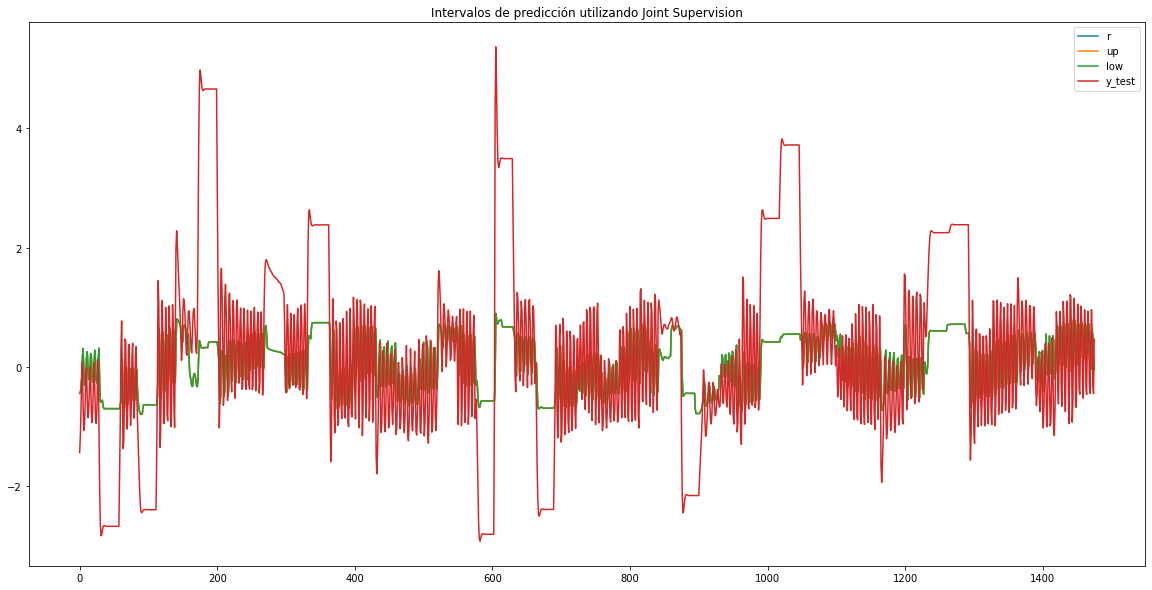

In [88]:
plt.figure(figsize=(20,10))
plt.plot(y_test_pred.detach().numpy(),label='r')
plt.plot(up.detach().numpy(),label='up')
plt.plot(low.detach().numpy(),label='low')
plt.plot(y_test,label='y_test')
plt.title('Intervalos de predicción utilizando Joint Supervision')
plt.legend()

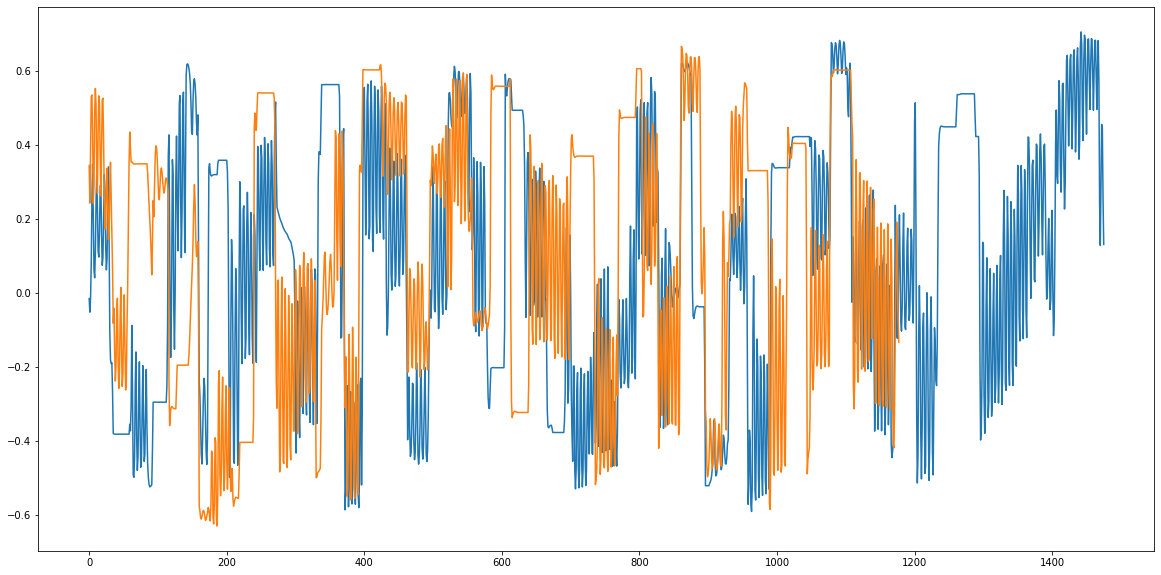

In [60]:
plt.figure(figsize=(20,10))
plt.plot(y_test_pred.detach().numpy(),label='r')
plt.plot(up.detach().numpy(),label='up')

In [0]:
y_pred.size()


In [0]:
y.size()

In [0]:
torch.zeros(1)

In [0]:
y_pred

In [0]:
y

In [0]:
y[0] - y_pred[0]

In [0]:
loss = criterion(y_pred, y)
loss_l = lower_loss(y_pred,y)
loss_u = upper_loss(y_pred,y)
print(t,'loss = ' ,loss.item(),'/  loss_l = ',loss_l.item(), '/  loss_u = ',loss_u.item())

In [0]:
loss

In [0]:
plt.plot(y)
plt.plot(y_pred.detach().numpy())

In [0]:
plt.plot(y_pred.detach().numpy())

In [0]:
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

In [0]:
[a,b]=[1 , 2]
a

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for i in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
